# Chapter 10 - Petrological thermodynamics of liquid and solid phases

In [21]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

## The equilibrium state

The partition coefficient $\parco_j$ is given by
\begin{equation*}
  \label{eq:equilibrium_partitioning_nonlinear}
  \parco_j = \left[\frac{\sum_k\left(\obar{\con}_k/\molarmass_k\right)\parco_k}
             {\sum_k\left(\obar{\con}_k/\molarmass_k\right)}\right]
             \exp\left[\frac{\Delta\enthalpy_j^{m}}{R/\molarmass_j}
             \left(\frac{1}{\temp} -
             \frac{1}{\melttemp_j}\right)\right].\nonumber
\end{equation*}

In cases where, for example, we use a small set of fictitious *effective* components to approximate the full thermochemical system, the error that we make in taking $\phasemolarmass\liq/\phasemolarmass\sol \approx 1$ is acceptably small. With this approach, the partition coefficient $\parco_j$ becomes

\begin{equation*}
  \label{eq:equilibrium_partitioning_simple}
  \parco_j(P,T) = \exp\left[\frac{\latent_j}{R_j}\left(\frac{1}{\temp} - \frac{1}{\melttemp_j(P)}\right)\right],
\end{equation*}

where $\latent_j\equiv-\Delta\enthalpy_j^m$ is the latent heat of melting for a solid composed of pure component $j$ and $R_j \equiv R/M_j$ is the modified gas constant.


Partition coefficients $\parco_j$ give an implicit equation for the equilibrium melt fraction $\equi\mf$ as

\begin{equation*}
  \label{eq:equilibrium-melt-frac-implicit}
  \sum_{j=1}^N\frac{\obar{\con}_j \left[1-\parco_j(\temp,\pres)\right]}{\equi\mf + (1-\equi\mf)\parco_j(\temp,\pres)} = 0,
\end{equation*}

Once a value of $\equi\mf$ has been numerically obtained, it can be used to determine the phase composition

\begin{align}
    \label{eq:equilib-phase-comp-liquid}
    \equi\con\liq_j &= \frac{\obar{\con}_j}{\equi\mf +
    (1-\equi\mf)\parco_j},\\
    \label{eq:equilib-phase-comp-solid}
    \equi\con\sol_j &= \frac{\obar{\con}_j}{\equi\mf/\parco_j +
                      (1-\equi\mf)}.
\end{align}


Table below shows parameter values for the two- and three-component ideal-solution systems. These values are useful for the demonstration of ideal-solution phase diagrams but should not be taken as an optimal calibration for the mantle.

| Name | $j$ | &nbsp; &nbsp; &nbsp; &nbsp; $\melttemp_j(P=0)$ [$^\circ$C] &nbsp; &nbsp; &nbsp; &nbsp; | $\clapeyron_j$ [GPa/K] | $\latent_j$ [kJ/kg] | $R_j$ [J/kg/K] |
|:---:|:---:|:---:|:---:|:---:|:---:|
| olivine | 1 | &nbsp; &nbsp; &nbsp; &nbsp; 1780 &nbsp; &nbsp; &nbsp; &nbsp; | 1/50 | 600 | 70 |
| basalt | 2 | &nbsp; &nbsp; &nbsp; &nbsp; 950 &nbsp; &nbsp; &nbsp; &nbsp; | 1/100 | 450 | 30 |
| hydrous basalt | 3 | &nbsp; &nbsp; &nbsp; &nbsp; 410 &nbsp; &nbsp; &nbsp; &nbsp; | 1/50 | 330 | 30 |

### Application to a two-pseudo-component system


The change of this melting temperature with pressure is given by the Clausius-Clapeyron equation. For simplicity, we assume a constant value of $\clapeyron = \Delta\entropy/\Delta(1/\density)$, which gives

\begin{equation}
  \label{eq:linear-solidus-relation}
  \temp^m_j(P) = \left.\temp^m_j\right\vert_{\pres=0} +
  \pres/\clapeyron.
\end{equation}

This produces the straight lines in Figure below (a) under the assumption that the thermodynamic pressure is lithostatic, i.e., $\Grad\pres=\density\gravity$.

In [22]:
class R_DMC_Calibration:
    def __init__(self, _nc=2, _np=300, _Tref=1350, _Tmin=950, _Tmax=1900, _Cref=(0.75, 0.25), _Pref=1, _Pmin=0,
                 _Pmax=7, _T0=(1780, 976), _A=(45, 107.4), _B=(-2.0, -2.83), _L=(600e3, 450e3), _r=(70, 40),
                 _Tm_P_mode='simonslaw', _dS=1.0, _K_T_mode='inverse_exp', _CompStr=('dunite', 'morb')):
        self.nc = _nc
        self.np = _np
        self.Tref = _Tref
        self.Tmin = _Tmin
        self.Tmax = _Tmax
        self.T_degC = np.linspace(self.Tmin, self.Tmax, self.np)
        self.Cref = np.asarray(_Cref)
        self.Pref = _Pref
        self.Pmin = _Pmin
        self.Pmax = _Pmax
        self.P_GPa = np.linspace(self.Pmin, self.Pmax, self.np)
        # ********* data from R_DMC_CalibrationTwoComponent
        self.T0 = np.asarray(_T0)  # set pure component melting points T_m^i at P=0
        self.A = np.asarray(_A)  # set coeff. for linear P-dependence of T_m^i [K/GPa]
        self.B = np.asarray(_B)  # set coeff. for quadratic P-dependence of T_m^i [K/GPa^2]
        self.L = np.asarray(_L)  # set latent heat of pure components L^i [J/kg]
        self.r = np.asarray(_r)  # set coeff. for T-dependence of distribution coefficients K^i
        # ********* data from IdealSolutionVsEutectic
        # self.T0 = np.asarray([2000, 1000])  # set pure component melting points T_m^i at P=0
        # self.A = np.asarray([0.0, 0.0])  # set coeff. for linear P-dependence of T_m^i [K/GPa]
        # self.B = np.asarray([0.0, 0.0])  # set coeff. for quadratic P-dependence of T_m^i [K/GPa^2]
        # self.L = np.asarray([500e3, 500e3])  # set latent heat of pure components L^i [J/kg]
        # self.r = np.asarray([60, 10])  # set coeff. for T-dependence of distribution coefficients K^i
        self.Tm_P_mode = _Tm_P_mode
        self.dS = _dS
        self.K_T_mode = _K_T_mode
        self.CompStr = _CompStr  # {'dunite~', 'morb~'}

In [23]:
class VAR:
    def __init__(self):
        self.C = None
        self.P = None
        self.T = None
        self.f = None
        self.Cl = None
        self.Cs = None

In [24]:
def SolLiqTemperature(C, Cref, M, Tref):
    return Tref + M * (C - Cref)


def SolLiqComposition(T, Tref, M, Cref):
    return Cref + (T - Tref) / M


def MeltFraction(T, C, ML, MS, LCref, SCref, Tref):
    TS = SolLiqTemperature(C, SCref, MS, Tref)
    TL = SolLiqTemperature(C, LCref, ML, Tref)
    Cs = SolLiqComposition(T, Tref, MS, SCref)
    Cl = SolLiqComposition(T, Tref, ML, LCref)
    F = (C-Cs)/(Cl-Cs)
    F[T <= TS] = 0
    F[T >= TL] = 1
    Cs[T < TS] = C
    Cl[T < TS] = np.nan
    return F, Cs, Cl

In [25]:
def liquidusFunction(FF, HH, CC, r_dmc_calib, cp, sf):
    TT = (HH-FF*r_dmc_calib.L[0])/cp + r_dmc_calib.T0[1]
    XX = (TT-r_dmc_calib.T0[1])/(r_dmc_calib.T0[0]-r_dmc_calib.T0[1])
    Cl = 1 - ((1-sf)*XX + sf * XX**3)
    return FF*Cl - CC


def meltFractionEutectic(H, C, T0, Te, L, cp, r_dmc_calib, sf):
    He_low = 0
    He_high = L * C[1]
    Hl = cp * (T0 - C[1]*(T0-Te) - Te) + L
    F, T = np.zeros_like(H), np.zeros_like(H)
    for j, Hj in enumerate(H):
        if Hj <= He_low:
            F[j] = 0.0
        elif H[j] <= He_high:
            F[j] = Hj/L
        else:
            F[j] = np.minimum(fsolve(lambda ff: liquidusFunction(ff, Hj, C[1], r_dmc_calib, cp, sf),
                                     np.asarray([0.5])), 1.0)
        T[j] = Te + (Hj-L*F[j])/cp
    return T, F

In [26]:
def TM(P, r_dmc_calib):
    # compute P - dependence of component melting points
    Tm = np.zeros((P.shape[0], r_dmc_calib.nc))
    if r_dmc_calib.Tm_P_mode is 'quadratic':
        r_dmc_calib.Tm = np.asarray([r_dmc_calib.T0[i] + r_dmc_calib.A[i] * P + r_dmc_calib.B[i] * P ** 2
                                     for i in np.arange(0, r_dmc_calib.nc)])
        # safeguard: continue melting point with linear slope above Pmax
        Pmax = 6
        T0 = np.asarray([r_dmc_calib.T0[i] + r_dmc_calib.A[i] * Pmax + r_dmc_calib.B[i] * Pmax ** 2
                         for i in np.arange(r_dmc_calib.nc)])
        dTdP = np.asarray([(r_dmc_calib.A[i] * Pmax + r_dmc_calib.B[i] * Pmax ** 2) -
                           (r_dmc_calib.A[i] * (Pmax - 0.01) + r_dmc_calib.B[i] * (Pmax - 0.01) ** 2)
                           for i in np.arange(r_dmc_calib.nc)]) / 0.01
        ind = P > Pmax
        for i in np.arange(r_dmc_calib.nc):
            Tm[ind, i] = T0 + dTdP * (P[ind] - Pmax)
    elif r_dmc_calib.Tm_P_mode is 'simonslaw':  # check below
        # Parameterization as in Rudge et al(2011)
        for i in np.arange(r_dmc_calib.nc):
            Tm[:, i] = r_dmc_calib.T0[i] * np.power(1.0 + P / r_dmc_calib.A[i], 1.0 / r_dmc_calib.B[i])
    return Tm

In [27]:
def K_(T, Tm, r_dmc_calib):
    # ** *compute T, P - dependence of equilibrium partition coefficients
    L = (T + 273.15) * r_dmc_calib.dS
    K = np.zeros((Tm.shape[0], r_dmc_calib.nc))
    if r_dmc_calib.K_T_mode is 'inverse_exp':
        # Parameterization after Rudge, Bercovici, & Spiegelman(2010)
        for i in np.arange(r_dmc_calib.nc):
            K[:, i] = np.exp(L[i] / r_dmc_calib.r[i] * (1.0 / (T + 273.15) - 1.0 / (Tm[:, i] + 273.15)))
    elif r_dmc_calib.K_T_mode is 'linear_exp':
        # Linearised exponential dependence
        for i in np.arange(r_dmc_calib.nc):
            K[:, i] = np.exp(-r_dmc_calib.r[i] * (T - Tm[:, i]))
    return L, K

In [28]:
def Tsolidus(var, r_dmc_calib):
    # ***** subroutine to compute solidus temperature at given bulk composition
    # *** exclude invalid compositions
    ii = np.sum(var.C[:, np.sum(var.C, axis=0) > 1], axis=1) <= 1
    # ** *get P - dependent pure - component    melting Temperature
    Tm = TM(var.P, r_dmc_calib)
    # ** *set starting guess for Tsol:
    Tsol = np.maximum(np.amin(Tm), np.minimum(np.amax(Tm), np.sum(var.C * Tm, axis=1)))
    # ** *get T - dependent partition coefficients Ki
    _, K = K_(Tsol, Tm, r_dmc_calib)
    # ** *get residual for sum(ci_b / Ki) = 1
    r = np.sum(var.C / K, axis=1) - 1

    rnorm = 1  # initialize residual norm for iterations
    n = 0  # initialize iteration count
    rnorm_tol = 1e-10  # tolerance for Newton residual
    its_tol = 500  # maximum number of iterations
    eps_T = 5  # temperature perturbation for finite differencing, degrees

    while rnorm > rnorm_tol:  # iterate down to full accuracy

        # ** *compute partition coefficients Ki at T + eps_T
        _, K = K_(Tsol + eps_T, Tm, r_dmc_calib)

        # ** *get residual at T + eps_T
        rp = np.sum(var.C / K, axis=1) - 1

        # ** *compute partition coefficients Ki at T - eps_T
        _, K = K_(Tsol - eps_T, Tm, r_dmc_calib)

        # ** *get residual at T - eps_T
        rm = np.sum(var.C / K, axis=1) - 1

        # ** *finite difference drdT = (r(T + eps_T) - r(T - eps_T)) / 2 / eps_T
        drdT = (rp - rm) / 2. / eps_T

        # ** *apply Newton correction to current guess of Tsol
        Tsol[ii] -= r[ii] / drdT[ii]

        # ** *compute partition coefficients Ki at Tsol
        _, K = K_(Tsol, Tm, r_dmc_calib)

        # ** *compute residual at Tsol
        r = np.sum(var.C / K, axis=1) - 1

        # ** *compute Newton residual norm
        rnorm = np.linalg.norm(r[ii], 2) / np.sqrt(len(r[ii]))

        n = n + 1  # update iteration count

        if n == its_tol:
            raise('!!! Newton solver for solidus T has not converged after ' + str(its_tol) + ' iterations !!!')

    return Tsol

In [29]:
def Tliquidus(var, r_dmc_calib):
    # subroutine to compute liquidus temperature at given bulk composition
    # ** *exclude invalid compositions
    ii = np.sum(var.C[:, np.sum(var.C, axis=0) > 1], axis=1) <= 1
    # ** *get P - dependent pure component melting T
    Tm = TM(var.P, r_dmc_calib)

    # ** *set starting guess for Tliq
    Tliq = np.maximum(np.amin(Tm), np.minimum(np.amax(Tm), np.sum(var.C * Tm, axis=1)))

    # ** *get T - dependent partition coefficients Ki
    _, K = K_(Tliq, Tm, r_dmc_calib)

    # ** *get residual for sum(ci_b * Ki) = 1
    r = np.sum(var.C * K, axis=1) - 1.0

    rnorm = 1  # initialize residual norm for iterations
    n = 0  # initialize iteration count
    rnorm_tol = 1e-10  # tolerance for Newton residual
    its_tol = 500  # maximum number o iterations
    eps_T = 1.0  # temperature perturbation for finite differencing, degrees

    while rnorm > rnorm_tol:  # iterate down to full accuracy

        # ** *compute partition coefficients Ki at T + eps
        _, K = K_(Tliq + eps_T, Tm, r_dmc_calib)

        # ** *get residual at T + eps_T
        rp = np.sum(var.C * K, axis=1) - 1

        # ** *compute partition coefficients Ki at T - eps_T
        _, K = K_(Tliq - eps_T, Tm, r_dmc_calib)

        # ** *get residual at T - eps_T
        rm = np.sum(var.C * K, axis=1) - 1

        # ** *compute difference drdT = (r(T + eps_T) - r(T - eps_T)) / 2 / eps_T
        drdT = (rp - rm) / 2. / eps_T

        # ** *apply Newton correction to Tliq
        Tliq[ii] -= r[ii] / drdT[ii]

        # ** *compute partition coefficients Ki at Tliq
        _, K = K_(Tliq, Tm, r_dmc_calib)

        # ** *compute residual at Tliq
        r = np.sum(var.C * K, axis=1) - 1

        # ** *compute Newton residual norm
        rnorm = np.linalg.norm(r[ii], 2) / np.sqrt(len(r[ii]))

        n = n + 1  # update iteration count

        if n == its_tol:
            raise Exception('Newton solver for liquidus T has not converged '
                            'after ' + str(its_tol) + ' iterations !!!')

    return Tliq

In [30]:
def Equilibrium(var, r_dmc_calib):
    # subroutine to compute equilibrium melt fraction and phase
    # compositions at given bulk composition, pressure and temperature

    # get Tsol, Tliq at C = [C1,C2,C3]
    Tsol = Tsolidus(var, r_dmc_calib)
    Tliq = Tliquidus(var, r_dmc_calib)

    # get P-dependent pure component melting T
    Tm = TM(var.P, r_dmc_calib)

    # get T-dependent partition coefficients Ki
    _, K = K_(np.maximum(Tsol, np.minimum(Tliq, var.T)), Tm, r_dmc_calib)

    # compute residual of unity sum of components
    ff = np.tile(var.f, (r_dmc_calib.nc, 1)).transpose()
    r = np.sum(var.C / (ff + (1 - ff) * K), axis=1) - np.sum(var.C / (ff / K + (1 - ff)), axis=1)

    rnorm = 1  # initialize residual norm for iterations
    n = 0  # initialize iteration count
    rnorm_tol = 1e-10  # tolerance for Newton residual
    its_tol = 100  # maximum number of iterations

    if (var.T <= Tsol).all():
        var.f[:] = 0  # no melt below sC1idus
    elif (var.T >= Tliq).all():
        var.f[:] = 1  # fully molten above liquidus
    else:
        while rnorm > rnorm_tol:  # Newton iteration

            # compute analytic derivative of residual dr/df
            dr_df = -np.sum(var.C * (1.0 - K) / (ff + (1 - ff) * K) ** 2, axis=1) \
                    + np.sum(var.C * (1 / K - 1) / (ff / K + (1 - ff)) ** 2, axis=1)

            # apply Newton correction to f
            a = 1
            while ((var.f - a * r / dr_df) < -1e-16).any() or (var.f - a * r / dr_df > 1 - 1e-16).any():
                a = a / 2
                if a < 1e-6:
                    raise Exception('R_DMC module: Newton solver for equilibrium melt fraction did not converge '
                                    'with step size {}!'.format(2 * a))
            var.f = var.f - a * r / dr_df

            # compute residual of unity sum of components
            ff = np.tile(var.f, (r_dmc_calib.nc, 1)).transpose()
            r = np.sum(var.C / (ff + (1 - ff) * K), axis=1) - np.sum(var.C / (ff / K + (1 - ff)), axis=1)

            # get non-linear residual norm
            rnorm = np.linalg.norm(r, 2) / np.sqrt(len(r))

            n = n + 1  # update iteration count
            if n == its_tol:
                raise Exception('Newton solver for equilibrium f did not converge'
                                ' after ' + str(its_tol) + ' iterations !!!')

    # get C_s^i, C_l^i as functions of K^i, C^i and f, safeguard bounds
    var.Cl = np.maximum(0.0, np.minimum(1.0, var.C / (ff + (1 - ff) * K)))
    VAR.Cs = np.maximum(0.0, np.minimum(1.0, var.C / (ff / K + (1 - ff))))

    # safeguard bounds on melt fraction against numerical leaks
    f = np.maximum(0, np.minimum(1.0, var.f))

    return var.T, f

In [31]:
def terncoords(c1, c2, c3):
    csum = c1 + c2 + c3
    c1, c2, c3 = c1/csum, c2/csum, c3/csum
    y = c2 * np.sin(np.radians(60))
    x = c1 + y / np.tan(np.radians(60))
    return x, y


def fractions(A, B, C):
    total = A + B + C
    fA, fB = A/total, B/total
    fC = 1-(fA+fB)
    return fA, fB, fC


def ternplot(A, B, C):
    fA, fB, fC = fractions(A, B, C)
    x, y = terncoords(fA, fB, fC)
    y, i = np.sort(y)
    x = x[i]
    return x, y


def simpletri(n):
    bl = np.arange(0, (n-1)*(n-1))
    br = bl + 1
    tl = bl + n
    tr = tl + 1
    tri1 = np.vstack([tl, bl, br])
    tri2 = np.vstack([tl, tr, br])
    tri = np.hstack([tri1, tri2]).transpose()
    return tri

In [32]:
def R_DMC_Equilibrium(var, r_dmc_calib, type):
    """
    main routine to compute various quantities depending input 'type'
    :param var:
    :param r_dmc_calib:
    :param type:
    :return:
    """

    if var.f is None:
        var.f = np.zeros_like(var.T)
    if var.C is None:
        var.C = np.zeros((len(var.T), r_dmc_calib.nc))
    if var.Cl is None:
        var.Cl = var.C
    if var.Cs is None:
        var.Cs = var.C

    # compute partition coefficients at P,T - this part is not used in "IdealSolutionVsEutectic.m"
    if type is 'K':
        Tm = TM(var.P, r_dmc_calib)
        _, K = K_(var.T, Tm, r_dmc_calib)
        return Tm, K
    # compute Tsol, Tliq at P,C^i
    if type is 'T':
        Tsol = Tsolidus(var, r_dmc_calib)
        Tliq = Tliquidus(var, r_dmc_calib)
        return Tsol, Tliq
    # compute equilibrium f, C_s^i, C_l^i fraction at P,T,C^i
    elif type is 'E':
        T, f = Equilibrium(var, r_dmc_calib)
        return T, f
    else:
        raise Exception('type {} not recognized'.format(type))

Ideal-solution model of a two-component system of _olivine_ ($j=1$) and _basalt_ ($j=2$). Parameter values are given in table above. __(a)__ Pure-component melting temperatures $\melttemp_j$ as a linear function of pressure. __(b)__ Partition coefficients $\parco_j$ as a function of temperature at a constant pressure of 1 GPa. __(c)__ Grey lines are the solidus and liquidus temperature as a function of the basalt fraction at a pressure of 1 GPa. The composition along the solidus curve refers to the solid phase; that along the liquidus curve refers to the liquid phase. Black lines indicate the compositional evolution of a closed system with bulk composition of 25% basalt component. __(d)__ Equilibrium melt fraction as a function of temperature for a bulk composition of 25% basalt component at 1 GPa.

In [33]:
r_dmc_calib = R_DMC_Calibration(_nc=2,
                                _np=300,
                                _Tref=1350,
                                _Tmin=1050,
                                _Tmax=1950,
                                _Cref=[0.75, 0.25],
                                _Pref=1,
                                _Pmin=0,
                                _Pmax=7,
                                _T0=[1780, 950],
                                _A=[45, 107.4],
                                _B=[-2.0, -2.83],
                                _L=[600e3, 450e3],
                                _r=[70.0, 30.0])

r2 = np.asarray([70, 50, 30, 10])
cI = len(r2) + 1
cp = 1200
sf = 0.3
H = np.linspace(-r_dmc_calib.L[0], r_dmc_calib.L[0] + cp * (r_dmc_calib.T0[0] - r_dmc_calib.T0[1]), 1000)

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(18.0, 18.0)

var = VAR()
var.P = r_dmc_calib.P_GPa
var.T = np.ones(r_dmc_calib.np) * r_dmc_calib.Tref
var.C = np.tile(r_dmc_calib.Cref, (r_dmc_calib.np, 1))
Tm, K = R_DMC_Equilibrium(var, r_dmc_calib, 'K')
ax[0, 0].plot(var.P, Tm[:, 0], '-k', linewidth=2, label=r'$T^\mathcal{S}_1$')
ax[0, 0].plot(var.P, Tm[:, 1], '--k', linewidth=2, label=r'$T^\mathcal{S}_2$')
ax[0, 0].set_xlabel('$P$, GPa', fontsize=20)
ax[0, 0].set_ylim(900, 2100)
ax[0, 0].set_ylabel(r'$T$, $^\circ$C', fontsize=20)
ax[0, 0].text(0.01, 0.99, r'(a)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax[0, 0].legend()

del var

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.C = np.tile(r_dmc_calib.Cref, (r_dmc_calib.np, 1))
_, K_b = R_DMC_Equilibrium(var, r_dmc_calib, 'K')
ax[0, 1].plot(var.T, K_b[:, 0], '-k', linewidth=2, label=r'$\check{K}_1$')
ax[0, 1].plot(var.T, K_b[:, 1], '--k', linewidth=2, label=r'$\check{K}_2$')
ax[0, 1].set_yscale('log')
ax[0, 1].set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax[0, 1].set_ylabel(r'${c}^s_j/{c}^\ell_j$', fontsize=20)
ax[0, 1].text(0.01, 0.99, r'(b)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax[0, 1].legend()
ax[0, 1].set_xlim(1050, 1950)

del var

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.f = np.zeros(r_dmc_calib.np)
var.C = np.tile(r_dmc_calib.Cref, (r_dmc_calib.np, 1))
# f, _ = R_DMC_Equilibrium(var, r_dmc_calib, 'E')
#var.Cs[1 - f < 1e-6, :] = np.nan
#var.Cl[f < 1e-6, :] = np.nan
# ax[1, 1].plot(var.T, var.f, '-k', linewidth=2)
ax[1, 1].set_xlim(1200, 1750)
Tf = var.T
ax[1, 1].set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax[1, 1].set_ylabel(r'$\check{f}$, wt. frac.', fontsize=20)
ax[1, 1].text(1200.0, 0.99, r'(d)', fontsize=18, verticalalignment='top', horizontalalignment='left')

del var

var = VAR()
var.C = np.zeros((r_dmc_calib.np, r_dmc_calib.nc))
var.C[:, 1] = np.linspace(0, 1, r_dmc_calib.np)
var.C[:, 0] = 1.0 - var.C[:, 1]
var.P = np.ones(r_dmc_calib.np) * r_dmc_calib.Pref
var.T = np.ones(r_dmc_calib.np) * r_dmc_calib.Tref
Tsol, Tliq = R_DMC_Equilibrium(var, r_dmc_calib, 'T')
ax[1, 0].plot(var.C[:, 1], Tsol, '-', linewidth=4, color=[0.7, 0.7, 0.7], label='phase boundary')
ax[1, 0].plot(var.C[:, 1], Tliq, '-', linewidth=4, color=[0.7, 0.7, 0.7])
ax[1, 0].plot(var.Cl[:, 1], Tf, '--k', linewidth=2, label=r'$\check{c}^\ell_2$')
ax[1, 0].plot(var.Cs[:, 1], Tf, '-k', linewidth=2, label=r'$\check{c}^s_2$')
ax[1, 0].set_xlabel(r'${c}^i_2$, wt. frac.', fontsize=20)
ax[1, 0].set_ylabel(r'$T$, $^\circ$C', fontsize=20)
ax[1, 0].text(1000., 0.99, f'(c)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax[1, 0].legend()
ax[1, 0].text(0.22, 1400, 'solid$+$liquid', fontsize=15)
ax[1, 0].text(0.72, 1500, 'liquid', fontsize=15)
ax[1, 0].text(0.05, 1150, 'solid', fontsize=15)

plt.show()

ValueError: Image size of 415157x1371 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1296x1296 with 4 Axes>

### Approaching the eutectic phase diagram

A eutectic phase diagram compared with ideal-solution phase loops for different values of $R_2$. Other ideal-solution 
parameters are $R_1=60$ J/kg/K, $\latent_1=\latent_2=500$ kJ/kg. __(a)__ Solidus and liquidus curves computed with ideal solution theory compared with the eutectic solidus and liquidus. __(b)__ Isobaric melting curves computed based on the phase loops and the eutectic.

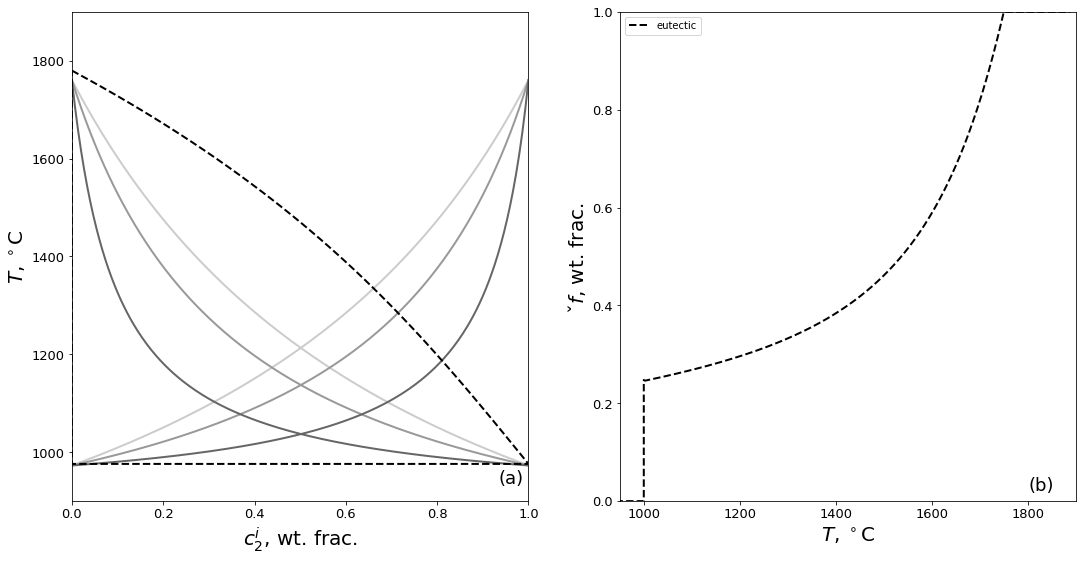

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18.0, 9.0)

r_dmc_calib = R_DMC_Calibration()

r2 = np.asarray([70, 50, 30, 10])
cI = len(r2) + 1
cp = 1200
sf = 0.3
H = np.linspace(-r_dmc_calib.L[0], r_dmc_calib.L[0] + cp * (r_dmc_calib.T0[0] - r_dmc_calib.T0[1]), 1000)

var = VAR()
var.C = np.zeros((r_dmc_calib.np, r_dmc_calib.nc))
var.C[:, 1] = np.linspace(0, 1, r_dmc_calib.np)
var.C[:, 0] = 1.0 - var.C[:, 1]
var.P = np.ones(r_dmc_calib.np) * r_dmc_calib.Pref
var.T = np.ones(r_dmc_calib.np) * r_dmc_calib.Tref
var.f = np.zeros(r_dmc_calib.np)

for i, r2i in enumerate(r2):
    r_dmc_calib.r[1] = r2i
    Tsol, Tliq = R_DMC_Equilibrium(var, r_dmc_calib, 'T')
    ax[0].plot(var.C[:, 0], Tsol, '-', linewidth=2, color=[1-i/cI, 1-i/cI, 1-i/cI])
    ax[0].plot(var.C[:, 1], Tliq, '-', linewidth=2, color=[1-i/cI, 1-i/cI, 1-i/cI])

T = np.linspace(r_dmc_calib.T0[0], r_dmc_calib.T0[1])
X = (T - r_dmc_calib.T0[1]) / (r_dmc_calib.T0[0] - r_dmc_calib.T0[1])
C_ = 1 - ((1 - sf) * X + sf * X ** 3)

ax[0].plot(np.hstack([C_, 0.0, 0.0]), np.hstack([T, r_dmc_calib.T0[1], r_dmc_calib.T0[0]]), '--k', linewidth=2)
ax[0].set_ylabel(r'$T$, $^\circ$C', fontsize=20)
ax[0].set_ylim(900, 1900)
ax[0].set_xlim(0.0, 1.0)
ax[0].set_xlabel(r'${c}^i_2$, wt. frac.', fontsize=20)
ax[0].text(0.99, 965.0, r'(a)', fontsize=18, verticalalignment='top', horizontalalignment='right')
ax[0].tick_params(axis='both', which='major', labelsize=13)

del var, T, X, C_

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.f = np.zeros(r_dmc_calib.np)
var.C = np.tile(r_dmc_calib.Cref, (r_dmc_calib.np, 1))
"""
for i, r2i in enumerate(r2):
    r_dmc_calib.r[1] = r2i
    f, _ = R_DMC_Equilibrium(var, r_dmc_calib, 'E')
    ax[1].plot(var.T, f, '-', linewidth=2, color=[1-i/cI, 1-i/cI, 1-i/cI], label=r'$R_2^*='+str(r2i)+'$ J/kg/K')
"""

H = np.linspace(-r_dmc_calib.L[0], r_dmc_calib.L[0] + cp * (r_dmc_calib.T0[0]-r_dmc_calib.T0[1]), 1000)
TE, FE = meltFractionEutectic(H, r_dmc_calib.Cref, 2000, 1000, 500e3, cp, r_dmc_calib, sf)
ax[1].plot(TE, FE, '--k', linewidth=2, label='eutectic')
ax[1].set_xlim(950, 1900)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax[1].set_ylabel(r'$\check{f}$, wt. frac.', fontsize=20)
ax[1].text(1800.0, 0.05, r'(b)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].legend()

plt.show()

### Application to a three-pseudo-component system

Ideal-solution model of a three-component system of *olivine* ($j=1$), *basalt* ($j=2$) and *hydrous basalt* ($j=3$). Parameter values are given in table above. __(a)__ Pure-component melting temperatures $\melttemp_j$ as a linear function of pressure. __(b)__ Partition coefficients $\parco_j$ as a function of temperature at a constant pressure of 1 GPa. __(c)__ Surfaces are the solidus and liquidus temperature through the full, 3-component space at a pressure of 1 GPa. The composition along the solidus surface refers to the solid phase; that along the liquidus surface refers to the liquid phase. The compositional evolution of the melt for a closed system with 75 wt% olivine and 0.2 wt% hydrous basalt is shown by the solid line. It starts at the triangle and progresses toward the circle with increasing $\temp$ and $\equi\mf$. __(d)__ Equilibrium melt fraction as a function of temperature for a bulk composition of 75 wt% olivine component with and without 0.2 wt% of hydrated basalt component at 1 GPa.

Exception: R_DMC module: Newton solver for equilibrium melt fraction did not converge with step size 1.9073486328125e-06!

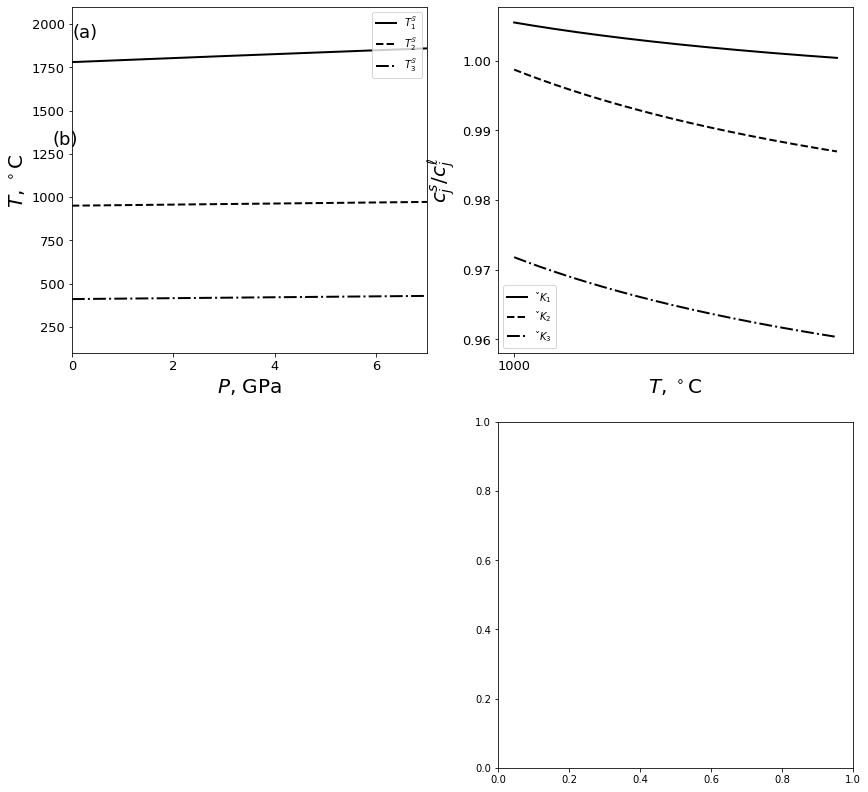

In [46]:
fig = plt.figure(figsize=plt.figaspect(2.))
gs = fig.add_gridspec(2, 2)
fig.set_size_inches(14.0, 14.0)

r_dmc_calib = R_DMC_Calibration(_nc=3, _np=400, _CompStr=['olivine', 'basalt', 'wet basalt'],
                                    _Tref=1350, _Tmin=1000, _Tmax=1700, _Pref=1, _Pmin=0, _Pmax=7,
                                    _Cref=[0.75, 0.248, 0.002], _T0=[1780, 950, 410], _A=[50, 100, 50], _B=[3, 3, 3],
                                    _L=[600e3, 450e3, 330e3], _r=[70, 30, 30])

var = VAR()
var.P = r_dmc_calib.P_GPa
var.T = np.ones(r_dmc_calib.np) * r_dmc_calib.Tref
var.C = r_dmc_calib.Cref

Tm, K = R_DMC_Equilibrium(var, r_dmc_calib, 'K')

ax00 = fig.add_subplot(gs[0, 0])

ax00.plot(var.P, Tm[:, 0], '-k', linewidth=2, label=r'$T^\mathcal{S}_1$')
ax00.plot(var.P, Tm[:, 1], '--k', linewidth=2, label=r'$T^\mathcal{S}_2$')
ax00.plot(var.P, Tm[:, 2], '-.k', linewidth=2, label=r'$T^\mathcal{S}_3$')
ax00.set_xlabel(r'$P$, GPa', fontsize=20)
ax00.set_ylabel(r'$T$, $^\circ$C', fontsize=20)
ax00.set_xlim(0, 7)
ax00.set_xticks((0, 2, 4, 6))
ax00.set_ylim(100, 2100)
ax00.text(0.01, 2000, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax00.tick_params(axis='both', which='major', labelsize=13)
ax00.legend()

del var, Tm, K

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.C = r_dmc_calib.Cref

Tm, K = R_DMC_Equilibrium(var, r_dmc_calib, 'K')

ax01 = fig.add_subplot(gs[0, 1])

ax01.plot(var.T, K[:, 0], '-k', linewidth=2, label=r'$\check{K}_1$')
ax01.plot(var.T, K[:, 1], '--k', linewidth=2, label=r'$\check{K}_2$')
ax01.plot(var.T, K[:, 2], '-.k', linewidth=2, label=r'$\check{K}_3$')
ax01.set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax01.set_xticks(np.arange(1000, 1701, 1000))
ax01.set_ylabel(r'${c}^s_j/{c}^\ell_j$', fontsize=20)
# ax[01].set_ylim(1e-4, 1e1)
# ax[01].set_yscale('log')
ax01.text(0.01, 0.99, r'(b)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax01.tick_params(axis='both', which='major', labelsize=13)
ax01.legend()

del var

ax11 = fig.add_subplot(gs[1, 1])

var_isobar = VAR()
var_isobar.T = r_dmc_calib.T_degC
var_isobar.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var_isobar.f = np.zeros(r_dmc_calib.np)
var_isobar.C = np.tile(r_dmc_calib.Cref, (r_dmc_calib.np, 1))
f_iso, _ = R_DMC_Equilibrium(var_isobar, r_dmc_calib, 'E')
var_isobar.Cs[1 - f_iso < 1e-6, :] = np.nan
var_isobar.Cl[f_iso < 1e-6, :] = np.nan
ax11.plot(var_isobar.T, f_iso, '-k', linewidth=2, label=r'wet')

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.f = np.zeros(r_dmc_calib.np)
var.C = np.tile(np.asarray([0.75, 0.25, 0.0]), (r_dmc_calib.np, 1))

f, _ = R_DMC_Equilibrium(var, r_dmc_calib, 'E')

var.Cs[1 - f < 1e-6, :] = np.nan
var.Cl[f < 1e-6, :] = np.nan
ax11.plot(var.T, f, '--k', linewidth=1, label='dry')
ax11.set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax11.set_ylabel(r'$\check{f}$, wt. frac.', fontsize=20)
ax11.set_xaxis(1000, 1500)
ax11.set_yaxis(0.0, 0.4)
ax11.text(0.01, 0.99, '(d)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.legend()

del var, f

ax10 = fig.add_subplot(gs[1, 0], projection='3d')

C3 = np.linspace(0, 1, r_dmc_calib.np)
C2 = np.linspace(0, 1, r_dmc_calib.np)
C2, C3 = np.meshgrid(C2, C3)
C2, C3 = C2.transpose().flatten(), C3.transpose().flatten()
C1 = 1 - C2 - C3
var = VAR()
var.C = np.zeros((r_dmc_calib.np * r_dmc_calib.np, r_dmc_calib.nc))
var.C[:, 0] = C1
var.C[:, 1] = C2
var.C[:, 2] = C3
var.P = np.ones(r_dmc_calib.np * r_dmc_calib.np) * r_dmc_calib.Pref
var.T = np.ones(r_dmc_calib.np * r_dmc_calib.np) * r_dmc_calib.Tref

Tsol, Tliq = R_DMC_Equilibrium(var, r_dmc_calib, 'T')

Tsol[var.C[:, 1] + var.C[:, 2] > 1] = np.nan
Tliq[var.C[:, 1] + var.C[:, 2] > 1] = np.nan
ax10.plot([0, 1, 0.5, 0], [0, 0, np.sin(1 / 3 * np.pi), 0], color=[0, 0, 0])
m = 5
grids = np.linspace(0, 100, m + 1)
grids = grids[0:-1]
labels = str(grids[1:])
x3, y3 = terncoords(100 - grids, grids, np.zeros(len(grids)))
x2, y2 = terncoords(grids, np.zeros(len(grids)), 100 - grids)
x1, y1 = terncoords(np.zeros(len(grids)), 100 - grids, grids)
n = m - 1
for i in np.arange(1, m):
    ax10.plot([x1[i], x2[n - i + 1]], [y1[i], y2[n - i + 1]], 'k:')
    ax10.plot([x2[i], x3[n - i + 1]], [y2[i], y3[n - i + 1]], 'k:')
    ax10.plot([x3[i], x1[n - i + 1]], [y3[i], y1[n - i + 1]], 'k:')
X, Y = terncoords(var.C[:, 1], var.C[:, 2], var.C[:, 0])
triangles = simpletri(r_dmc_calib.np)
tri = mtri.Triangulation(X.ravel(), Y.ravel(), triangles)
#ax10.plot_trisurf(tri, Tsol)
#ax10.plot_trisurf(tri, Tliq)
ax10.text(x3[1:]+0.09, y3[1:]-0.04, labels, fontsize=15)
ax10.text(x2[1:]+0.04, y2[1:]-0.12, labels, fontsize=15)
ax10.text(x1[1:]-0.09, y1[1:]+0.02, labels, fontsize=15)
ax10.text(0.44, 0.9, '${c}_3^i$', fontsize=15)
ax10.text(1.18, -0.09, '${c}_2^i$', fontsize=15)
ax10.text(-0.13, -0.030, '${c}_1^i$', fontsize=15)
ax10.plot(ternplot(var_isobar.Cl[:, 1], var_isobar.Cl[:, 2], var_isobar.Cl[:, 0]), '-k', linewidth=2)
ax10.plot(ternplot(r_dmc_calib.Cref[1], r_dmc_calib.Cref[2], r_dmc_calib.Cref[0]), 'ok', linewidth=2, markersize=8)
ax10.plot(ternplot(var_isobar.Cl[0, 1], var_isobar.Cl[0, 2], var_isobar.Cl[0, 0]), '<k', linewidth=2, markersize=8)
ax10.text(0.01, 0.99, '(c)', fontsize=18, verticalalignment='top', horizontalalignment='left')
ax10.tick_params(axis='both', which='major', labelsize=13)

plt.show()

### Linearising the two-component phase diagram

Phase diagrams constructed with ideal solution theory provide a useful basis for developing the melting relations required for magma/mantle dynamics. Their nonlinearity, however, precludes a use in analytical calculations; instead they must be handled numerically. It is therefore important to formulate an approximation in which the equilibrium state is computed analytically.

For linear variations in pressure and composition, we can write

  \begin{align}
    \label{eq:col-twocomp-pd-solidus}
    \soltemp &= \soltemp_\text{ref} + (\pres-\pres_\text{ref})/\clapeyron  +
               \solslope\left(\equi\con\sol - \equi\con\sol_{\text{ref}}\right),\\
  \label{eq:col-twocomp-pd-deltac}
    \equi\con\liq &= \equi\con\sol - \Delta\equi\con,
  \end{align}

where $\solslope$ is the constant slope of the solidus with concentration in the two component space and $\soltemp_\text{ref}$ is a reference temperature at $\pres=\pres_\text{ref}$ and $\equi\con\sol=\equi\con\sol_\text{ref}$.  Also, $\Delta\equi\con \equiv \equi\con\sol - \equi\con\liq$ is the concentration difference between the solidus and the liquidus.  If $\Delta\equi\con$ is taken to be a constant then the liquidus slope $\liqslope$ and the solidus slope $\solslope$ are equal.



Figure below plots a comparison of a two-component, ideal-solution phase loop with a linearised solidus and liquidus at 1 GPa. The phase loop uses the parameters from the Table above. __(a)__ Solidus and liquidus curves.  Evolution of an initially unmolten rock with 25 wt% basaltic component for increasing temperature, along the linearised phase boundaries. __(b)__ Isobaric melting curves.

/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeW

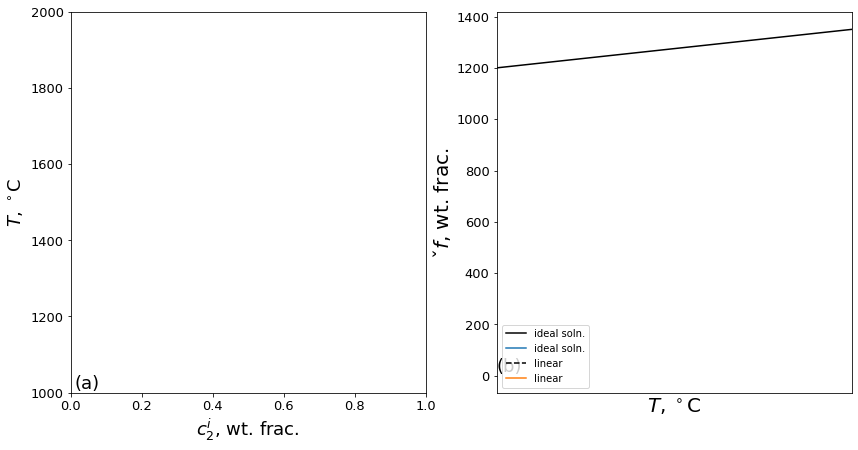

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14.0, 7.0)

r_dmc_calib = R_DMC_Calibration(_Tref=1350, _Tmin=900, _Tmax=1350, _Cref=[0.75, 0.25], _Pref=1, _Pmin=0, _Pmax=7,
                                    _T0=[1780, 950], _A=[45, 112], _B=[0, 0], _L=[600e3, 450e3], _r=[70, 30])

var = VAR()
var.C = np.zeros((r_dmc_calib.np, r_dmc_calib.nc))
var.C[:, 1] = np.linspace(0, 1, r_dmc_calib.np)
var.C[:, 0] = 1.0 - var.C[:, 1]
var.P = np.ones(r_dmc_calib.np) * r_dmc_calib.Pref
var.T = np.ones(r_dmc_calib.np) * r_dmc_calib.Tref

Tsol, Tliq = R_DMC_Equilibrium(var, r_dmc_calib, 'T')

Cint = r_dmc_calib.Cref[1] * np.asarray([0.999, 1.001])
Tint = interp1d(var.C[:, 1], Tsol)(Cint)
MS = (Tint[1] - Tint[0]) / (Cint[1] - Cint[0])
Tref = np.mean(Tint)
Cint = interp1d(Tliq, var.C[:, 1])(Tint)
ML = (Tint[1] - Tint[0]) / (Cint[1] - Cint[0])
Cref = np.mean(Cint)
F, Cs, Cl, = MeltFraction(r_dmc_calib.T_degC, r_dmc_calib.Cref[1], ML, MS, Cref, r_dmc_calib.Cref[1], Tref)

gr = 0.6
ax[0].plot(var.C[:, 1], Tsol, '-', linewidth=3, color=[gr, gr, gr])
ax[0].plot(var.C[:, 1], Tliq, '-', linewidth=3,
           color=[gr, gr, gr], label=r'$T^\mathcal{S},T^\mathcal{L}$ (ideal soln.)')
ax[0].plot(var.C[:, 1], SolLiqTemperature(var.C[:, 1], Cref, ML, Tref), '--',
           color=[gr, gr, gr], linewidth=3, label=r'$T^\mathcal{S},T^\mathcal{L}$ (linear)')
ax[0].plot(var.C[:, 1], SolLiqTemperature(var.C[:, 1], r_dmc_calib.Cref[1], MS, Tref), '--',
           color=[gr, gr, gr], linewidth=3)
ax[0].plot(Cs, r_dmc_calib.T_degC, '-k', linewidth=1.5, label=r'$\check{c}^s_2(T),\check{c}^\ell_2(T)$, (linear)')
ax[0].plot(Cl, r_dmc_calib.T_degC, '-k', linewidth=1.5)
ax[0].set_ylabel(r'$T$, $^\circ$C', fontsize=18)
ax[0].set_xlabel(r'${c}^i_2$, wt. frac.', fontsize=18)
ax[0].text(0.01, 1000, r'(a)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(1000, 2000)
ax[0].tick_params(axis='both', which='major', labelsize=13)

del var

var = VAR()
var.T = r_dmc_calib.T_degC
var.P = r_dmc_calib.Pref * np.ones(r_dmc_calib.np)
var.f = np.zeros(r_dmc_calib.np)
var.C = np.tile(r_dmc_calib.Cref, (r_dmc_calib.np, 1))
f, _ = R_DMC_Equilibrium(var, r_dmc_calib, 'E')
ax[1].plot(var.T, f, '-k', 'linewidth', 2, label='ideal soln.')
ax[1].plot(var.T, F, '--k', 'linewidth', 2, label='linear')
ax[1].set_xlabel(r'$T$, $^\circ$C', fontsize=20)
ax[1].set_ylabel(r'$\check{f}$, wt. frac.', fontsize=20)
ax[1].text(1200, 0.01, r'(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
ax[1].set_xlim(1200, 1350)
ax[1].tick_params(axis='both', which='major', labelsize=13)

plt.legend()
plt.show()